In [17]:
import os, glob, math, json
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

# 0. Data Pre-analysis

In [5]:
train_width, train_height = [], []
train_channel = set()

In [8]:
for prog in os.listdir('dataset'):
    for fname in glob.glob(os.path.join('dataset', prog, '*.png')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
assert len(train_width) == len(train_height), "# Mismatch between height and width!"

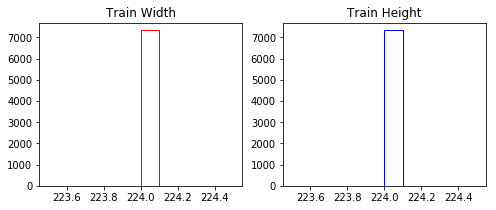

In [26]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title('Train Width')
plt.hist(train_width, color='red', label='Width', histtype='step')
plt.subplot(1, 2, 2)
plt.title('Train Height')
plt.hist(train_height, color='blue', label='Height', histtype='step')
plt.show()

In [27]:
print ('Image Channel: ', train_channel)

Image Channel:  {('L',)}


In [85]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
INPUT_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [86]:
print ("Getting Training Data")
trainGenerator = ImageDataGenerator(
                rescale=1./255, 
                rotation_range=30,
                zoom_range=0.15,
                width_shift_range=0.15, 
                height_shift_range=0.15, 
                horizontal_flip=True,
                vertical_flip=True,
                validation_split=0.2
                )

print ("Subsampling Training Set")
train_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory='dataset',
                    target_size=INPUT_SIZE,
                    subset='training',
                    color_mode='grayscale')

print ("Subsampling Validation Set")
val_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory='dataset',
                    target_size=INPUT_SIZE,
                    subset='validation',
                    color_mode='grayscale')

labels = {z: dis for z, dis in enumerate(os.listdir('dataset'))}
print ("Labels: ", labels)

Getting Training Data
Subsampling Training Set
Found 2931 images belonging to 5 classes.
Subsampling Validation Set
Found 731 images belonging to 5 classes.
Labels:  {0: 'Mild', 1: 'No_DR', 2: 'Proliferate_DR', 3: 'Moderate', 4: 'Severe'}


TypeError: Invalid dimensions for image data

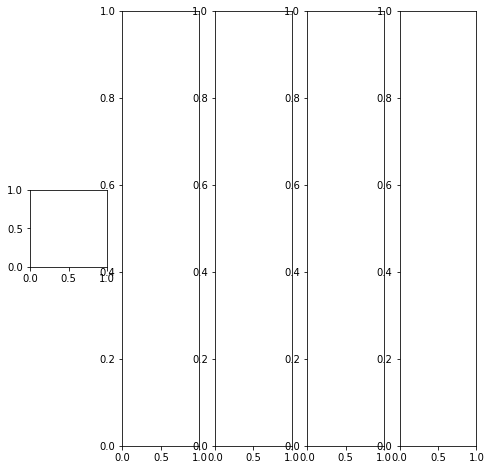

In [87]:
def decodeOneHot(one_hot_vector):
    return np.argmax(one_hot_vector)

def plotImages(images_arr, label_arr):
    """
    Displays a selection of images (e.g. from training dataset)
    with their appropriate labels.
    Input: array_of_images[n], 
        where n takes the form of array slicer.
    Output: plot(s) of rescaled images with their curated annotation.
    """
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        ax.imshow(img)
        ax.set_xlabel(labels[decodeOneHot(dataLabel)])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()


sample_train, label = next(train_data)
plotImages(sample_train[:5], label[:5])

In [88]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
                           input_shape=INPUT_SIZE),
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=111),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4, seed=111),
    Dense(5, activation='softmax')
    ])
model.compile(optimizer=optimizers.Adam(epsilon=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()
now = datetime.strftime(datetime.today(), '%Y%m%d_%H%M')

ValueError: Input 0 of layer conv2d_5 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 224, 224]